In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.rcdefaults()

/data/public/dulin/miniconda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

adata = sc.read_10x_h5('./demo_data/10x visium_orchid/filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
print(adata)

2024-10-28 11:33:55.630971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 11:33:57.078953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.9.2 anndata==0.10.7 umap==0.5.6 numpy==1.23.5 scipy==1.10.0 pandas==1.4.0 scikit-learn==1.1.2 statsmodels==0.14.2 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.12
reading ./demo_data/10x visium_orchid/filtered_feature_bc_matrix.h5
 (0:00:00)
AnnData object with n_obs × n_vars = 2379 × 28903
    var: 'gene_ids', 'feature_types', 'genome'


In [4]:
img = pd.read_csv('./demo_data/10x visium_orchid/spatial/tissue_positions_list.csv',sep = ',')
img

,barcode,sample_name,row,col,imagerow,imagecol
0,ACGCCTGACACGCGCT-1,0,0,0,22722,22480
1,TACCGATCCAACACTT-1,0,1,1,22455,22324
2,ATTAAAGCGGACGAGC-1,0,0,2,22724,22172
3,GATAAGGGACGATTAG-1,0,1,3,22457,22016
4,GTGCAAATCACCAATA-1,0,0,4,22726,21863
...,...,...,...,...,...,...
4987,GAACGTTTGTATCCAC-1,0,77,123,2168,3372
4988,ATTGAATTCCCTGTAG-1,0,76,124,2437,3219
4989,TACCTCACCAATTGTA-1,0,77,125,2170,3063
4990,AGTCGAATTAGCGTAA-1,0,76,126,2439,2910


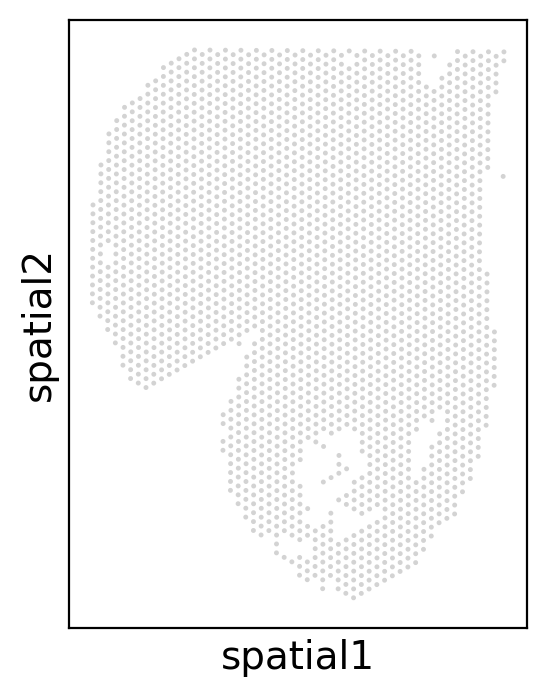

AnnData object with n_obs × n_vars = 2379 × 28903
    obs: 'cluster_gt'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cluster_gt_colors'
    obsm: 'spatial'

In [8]:
df2 = img[['barcode','imagerow','imagecol']]
barcode2 = img.barcode.tolist()
barcode = adata.obs.index.tolist()

df1 = pd.DataFrame()
df1['barcode'] = barcode
df3 = pd.merge(df1,df2,on='barcode',how='left') #按照barcode
coo = df3.groupby("barcode").mean()[['imagerow','imagecol']]
adata.obsm['spatial'] = coo.to_numpy()

sc.pl.spatial(adata,  spot_size=170)   
adata

In [10]:
def convert_adata(adata,save):
    if sparse.issparse(adata.X):
        csc = adata.X.tocsc()
    else:
        csc = sparse.csc_matrix(adata.X)
    df = pd.DataFrame()
    tmp = []
    for i in range(csc.shape[1]):
        tmp += [i] * (csc.indptr[i + 1] - csc.indptr[i])   
    df['geneID'] = np.array(tmp)
    df['label'] = csc.indices
    df['MIDCount'] = csc.data
    df[['x', 'y']] = adata.obsm['spatial'][df['label']]
    df['geneID'] = adata.var.index[df['geneID']]
    # df['tissue']= adata.obs['cluster_gt'][df['label']].tolist()
    df_gem = df[['geneID', 'x', 'y', 'MIDCount', "label"]]
    if isinstance(save, str):
        df_gem.to_csv(save, sep='\t', index=False)
    return df_gem

df_gem = convert_adata(adata,"./input/Visium_to_gem/demoe_visium_orchid.cellbin.gem")
df_gem

,geneID,x,y,MIDCount,label
0,PAXXG000020,10170.0,11754.0,1.0,20
1,PAXXG000020,13080.0,18717.0,1.0,41
2,PAXXG000020,19562.0,12585.0,1.0,47
3,PAXXG000020,16610.0,12412.0,2.0,55
4,PAXXG000020,13415.0,8071.0,1.0,65
...,...,...,...,...,...
6201212,PAXXG342760,13667.0,10696.0,1.0,2322
6201213,PAXXG342760,17676.0,13653.0,2.0,2348
6201214,PAXXG342760,13975.0,4372.0,1.0,2362
6201215,PAXXG342760,12372.0,3127.0,1.0,2363
